Aim: To mathematically show that all the classes are distinct 

In [82]:
import os
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re
from collections import defaultdict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist,squareform


First load all of the data into a pandas dataframe 

In [2]:
def load_datasets(base_path='./../datasets'):
    data = []
    classes = ['class_1', 'class_2', 'class_3']
    
    for label in classes:
        folder_path = os.path.join(base_path, label)
        if not os.path.exists(folder_path):
            continue
            
        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):
                with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                    content = f.read()
                    data.append({
                        'filename': filename,
                        'text': content,
                        'class': label
                    })
    return pd.DataFrame(data)

df = load_datasets()
print(f"Loaded {len(df)} documents across {df['class'].nunique()} classes.")

Loaded 24 documents across 3 classes.


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   filename  24 non-null     str  
 1   text      24 non-null     str  
 2   class     24 non-null     str  
dtypes: str(3)
memory usage: 708.0 bytes


Have everything we are trying over here , keep updating this shit 

TTR(Type Token Ratio) 

= Types(Num Unique words)/Token(Total words)

Helps understand how rich the text is in terms of vocabulary

Since the text is quite long and uneven, lets use a window, calculate the TTR within the windows and generalise to the document. 

In [4]:
def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

def windowed_ttr(tokens, window_size):
    if len(tokens) < window_size:
        return None  # too short to be comparable
    
    ttrs = []
    for i in range(0, len(tokens) - window_size + 1, window_size):
        window = tokens[i:i + window_size]
        ttr = len(set(window)) / window_size
        ttrs.append(ttr)
    
    return np.mean(ttrs)

In [26]:
class_results = defaultdict(list)
file_ttr_results = defaultdict()
for _, row in df.iterrows():
    tokens = tokenize(row["text"])
    ttr = windowed_ttr(tokens, window_size=1000)
    
    if ttr is not None:
        class_results[row["class"]].append(ttr)
        file_ttr_results[row['filename']] = ttr

In [28]:
print("1000-word Windowed TTR (MSTTR-style)\n")

for cls, values in class_results.items():
    values = np.array(values)
    
    print(f"Class: {cls}")
    print(f"  Documents used : {len(values)}")
    print(f"  Mean TTR       : {values.mean():.4f}")
    print(f"  Std Dev        : {values.std():.4f}")
    print(f"  Min/Max      : {values.min():.4f}/{values.max():.4f}")
    print()

1000-word Windowed TTR (MSTTR-style)

Class: class_1
  Documents used : 4
  Mean TTR       : 0.4023
  Std Dev        : 0.0216
  Min/Max      : 0.3671/0.4245

Class: class_2
  Documents used : 10
  Mean TTR       : 0.4289
  Std Dev        : 0.0357
  Min/Max      : 0.3767/0.4855

Class: class_3
  Documents used : 10
  Mean TTR       : 0.4478
  Std Dev        : 0.0251
  Min/Max      : 0.4092/0.4806



It would maybe be more interesting to look at 
1. Density of TTR ranges in classes: understand the distribution and also check the overlap between classes or the existence of specific cluster points. 
2. How TTR changes through the document. 

In [7]:
def sliding_window_ttrs(tokens, window_size=500, step=None):
    if step is None:
        step = window_size  # non-overlapping by default
    
    ttrs = []
    positions = []
    
    for i in range(0, len(tokens) - window_size + 1, step):
        window = tokens[i:i + window_size]
        ttr = len(set(window)) / window_size
        ttrs.append(ttr)
        positions.append(i)
    
    return positions, ttrs

In [8]:
window_data = []
max_tokens = 6000

for _, row in df.iterrows():
    tokens = tokenize(row["text"])
    
    if len(tokens) < 500:
        continue
    
    tokens = tokens[:max_tokens]  # length normalization
    
    positions, ttrs = sliding_window_ttrs(
        tokens,
        window_size=500,
        step=500
    )
    
    for pos, ttr in zip(positions, ttrs):
        window_data.append({
            "class": row["class"],
            "filename": row["filename"],
            "position": pos,
            "ttr": ttr
        })

wd_df = pd.DataFrame(window_data)

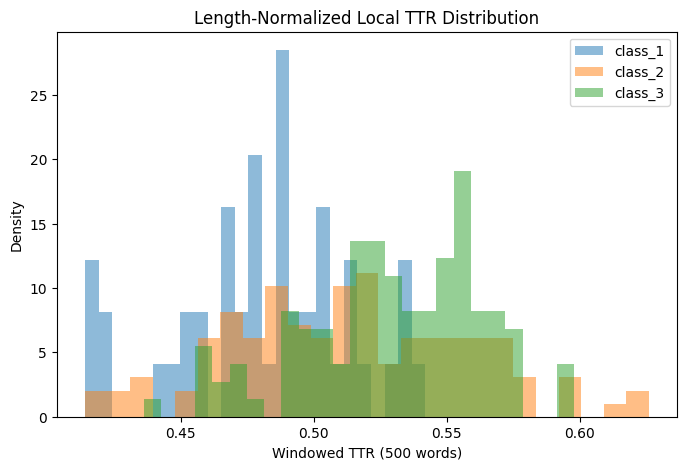

In [9]:
plt.figure(figsize=(8, 5))

for cls in wd_df["class"].unique():
    subset = wd_df[wd_df["class"] == cls]["ttr"]
    plt.hist(subset, bins=25, alpha=0.5, density=True, label=cls)

plt.xlabel("Windowed TTR (500 words)")
plt.ylabel("Density")
plt.title("Length-Normalized Local TTR Distribution")
plt.legend()
plt.show()


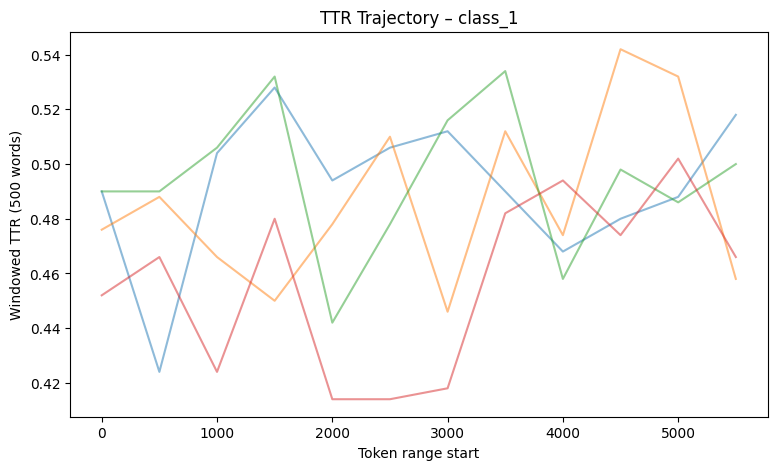

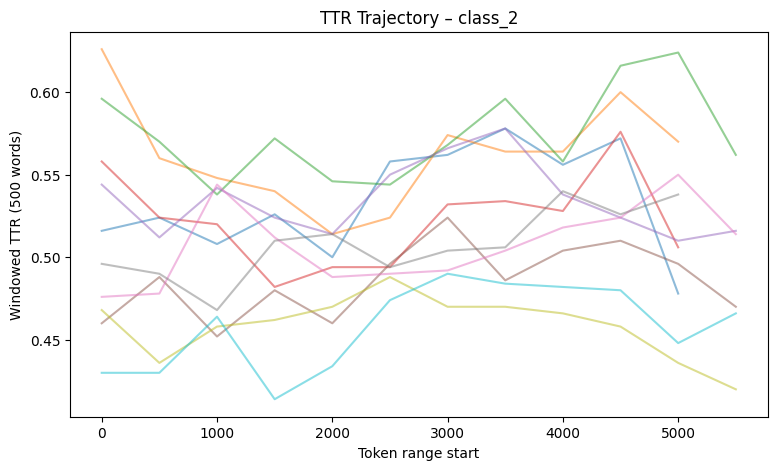

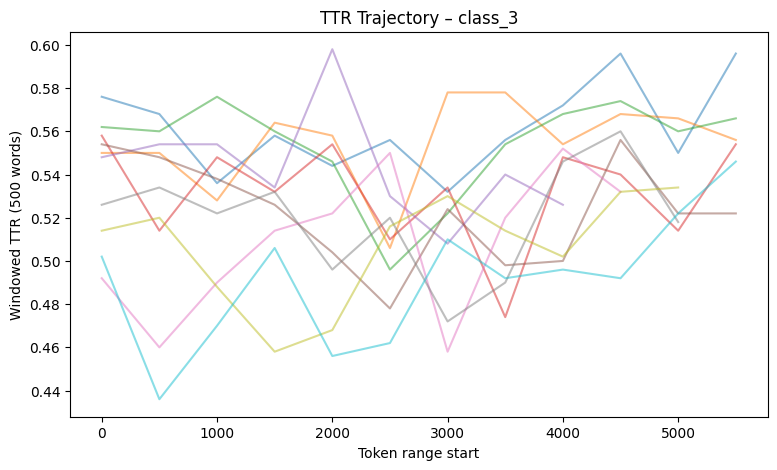

In [10]:
for cls in wd_df["class"].unique():
    plt.figure(figsize=(9, 5))
    
    subset = wd_df[wd_df["class"] == cls]
    
    for fname, group in subset.groupby("filename"):
        plt.plot(
            group["position"],
            group["ttr"],
            alpha=0.5
        )
    
    plt.xlabel("Token range start")
    plt.ylabel("Windowed TTR (500 words)")
    plt.title(f"TTR Trajectory – {cls}")
    plt.show()


Class 1 (Human):
    Much tighter bands, normal like distribution with TTR mostly around 0.46-0.5

Class 2 (AI):
    Normal like distribution but a very broad and evenly spread band. Local TTR varies heavily all the way from 0.42-0.64.

Class 3 (AI mimic):
    More heavy tail like distribution, often has high local TTR. Very uneven TTR across the text and usually shoot up towards the end as seen roughly from the TTR trajectory graphs. 

Lets now try a new measure, 

Hapax Legomena: 

In [11]:
def hapax_ratio(tokens):
    counts = Counter(tokens)
    hapax = sum(1 for w, c in counts.items() if c == 1)
    return hapax / len(tokens)

def windowed_hapax(tokens, window_size=5000):
    n = len(tokens)
    ratios = []
    
    for i in range(0, n - window_size + 1, window_size):
        window = tokens[i:i + window_size]
        ratios.append(hapax_ratio(window))
    
    return ratios

In [29]:
class_hapax = defaultdict(list)
file_hapax_results = defaultdict()

for _, row in df.iterrows():
    tokens = tokenize(row["text"])
    hapax_vals = windowed_hapax(tokens, window_size=5000)

    if len(hapax_vals) == 0:
        continue

    #mean hapax over windows
    file_hapax_mean = np.mean(hapax_vals)
    class_hapax[row["class"]].append(file_hapax_mean)
    file_hapax_results[row['filename']] = file_hapax_mean


In [31]:
print("Class-wise Hapax Legomena Metrics (5000-word windows)\n")

for cls, values in class_hapax.items():
    values = np.array(values)

    print(f"Class: {cls}")
    print(f"  Files used      : {len(values)}")
    print(f"  Mean hapax      : {values.mean():.4f}")
    print(f"  Std deviation  : {values.std():.4f}")
    print(f"  Min/Max      : {values.min():.4f}/{values.max():.4f}")
    print()


Class-wise Hapax Legomena Metrics (5000-word windows)

Class: class_1
  Files used      : 4
  Mean hapax      : 0.1515
  Std deviation  : 0.0197
  Min/Max      : 0.1181/0.1666

Class: class_2
  Files used      : 10
  Mean hapax      : 0.1400
  Std deviation  : 0.0103
  Min/Max      : 0.1214/0.1532

Class: class_3
  Files used      : 9
  Mean hapax      : 0.1546
  Std deviation  : 0.0164
  Min/Max      : 0.1268/0.1792



Hapax alone doesnt seem like a good metric

Lets try using POS

In [33]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "lemmatizer"])
WINDOW_SIZE = 5000

print(f"{'Class':<12} | {'Filename':<15} | {'Adj/Noun Ratio':<15}")

pos_stats = {'class_1': [], 'class_2': [], 'class_3': []}
file_pos_results = defaultdict()

for _, row in df.iterrows():
    words = row['text'].split()[:WINDOW_SIZE]
    sample_text = " ".join(words)
    
    if len(words) >= WINDOW_SIZE:
        doc = nlp(sample_text)
        
        counts = Counter([token.pos_ for token in doc])
        adj_count = counts.get('ADJ', 0)
        noun_count = counts.get('NOUN', 0) + counts.get('PROPN', 0) #include Proper Nouns
        
        ratio = adj_count / noun_count if noun_count > 0 else 0
        
        print(f"{row['class']:<12} | {row['filename']:<15} | {ratio:.4f}")
        pos_stats[row['class']].append(ratio)
        file_pos_results[row['filename']] = ratio
    else:
        print(f"{row['class']:<12} | {row['filename']:<15} | [SKIP]")

Class        | Filename        | Adj/Noun Ratio 
class_1      | a2.txt          | 0.4157
class_1      | a1.txt          | 0.4598
class_1      | b1.txt          | 0.3876
class_1      | b2.txt          | 0.3605
class_2      | a1_t1.txt       | 0.5235
class_2      | a2_t4.txt       | 0.4713
class_2      | a1_t2.txt       | 0.5280
class_2      | b1_t7.txt       | 0.3750
class_2      | b1_t10.txt      | 0.4362
class_2      | a2_t5.txt       | 0.5045
class_2      | b1_t6.txt       | 0.4042
class_2      | b1_t8.txt       | 0.4244
class_2      | b1_t9.txt       | 0.4528
class_2      | a1_t3.txt       | 0.5097
class_3      | b1m_t6.txt      | 0.4469
class_3      | a1m_t3.txt      | 0.5011
class_3      | b2m_t8.txt      | 0.5108
class_3      | b1m_t7.txt      | 0.3590
class_3      | a1m_t2.txt      | 0.5471
class_3      | a1m_t1.txt      | 0.5380
class_3      | a2m_t5.txt      | [SKIP]
class_3      | b2m_t10.txt     | 0.4728
class_3      | a2m_t4.txt      | 0.4606
class_3      | b2m_t9.txt      

In [36]:
print("Avg adj to noun ratio")
for cls, ratios in pos_stats.items():
    if ratios:
        avg = sum(ratios) / len(ratios)
        print(f"{cls:<12}: Avg Ratio = {avg:.4f}")

Avg adj to noun ratio
class_1     : Avg Ratio = 0.4059
class_2     : Avg Ratio = 0.4630
class_3     : Avg Ratio = 0.4908


Much stronger result as compared to Hapax and TTR, we can clearly see AI trying to "over describe" nouns. Humans usually just reuse nouns once established and dont descibe them again and again which matches with what we have here

Dependency stuff 

In [16]:
def token_depth(token):
    depth = 0
    while token.head != token:
        token = token.head
        depth += 1
    return depth

def avg_dependency_depth(text):
    doc = nlp(text)
    sent_depths = []

    for sent in doc.sents:
        depths = [token_depth(tok) for tok in sent]
        if depths:
            sent_depths.append(max(depths))

    if not sent_depths:
        return None

    return np.mean(sent_depths)

In [17]:
file_depths = []

for _, row in df.iterrows():
    depth = avg_dependency_depth(row["text"])
    
    if depth is None:
        continue

    file_depths.append({
        "filename": row["filename"],
        "class": row["class"],
        "avg_dep_depth": depth
    })


In [18]:
print("Dependency Tree Depth per File\n")

for r in file_depths:
    print(f"{r['filename']:<15} ({r['class']}) : Avg Depth = {r['avg_dep_depth']:.2f}")


Dependency Tree Depth per File

a2.txt          (class_1) : Avg Depth = 7.46
a1.txt          (class_1) : Avg Depth = 7.30
b1.txt          (class_1) : Avg Depth = 6.76
b2.txt          (class_1) : Avg Depth = 6.60
a1_t1.txt       (class_2) : Avg Depth = 7.24
a2_t4.txt       (class_2) : Avg Depth = 6.56
a1_t2.txt       (class_2) : Avg Depth = 6.92
b1_t7.txt       (class_2) : Avg Depth = 6.39
b1_t10.txt      (class_2) : Avg Depth = 6.15
a2_t5.txt       (class_2) : Avg Depth = 6.61
b1_t6.txt       (class_2) : Avg Depth = 6.26
b1_t8.txt       (class_2) : Avg Depth = 6.22
b1_t9.txt       (class_2) : Avg Depth = 6.14
a1_t3.txt       (class_2) : Avg Depth = 6.71
b1m_t6.txt      (class_3) : Avg Depth = 6.96
a1m_t3.txt      (class_3) : Avg Depth = 7.43
b2m_t8.txt      (class_3) : Avg Depth = 6.04
b1m_t7.txt      (class_3) : Avg Depth = 6.79
a1m_t2.txt      (class_3) : Avg Depth = 7.27
a1m_t1.txt      (class_3) : Avg Depth = 7.44
a2m_t5.txt      (class_3) : Avg Depth = 6.58
b2m_t10.txt     (class_

In [19]:
class_depths = defaultdict(list)

for r in file_depths:
    class_depths[r["class"]].append(r["avg_dep_depth"])

print("\nClass-wise Dependency Tree Depth Metrics\n")

for cls, values in class_depths.items():
    values = np.array(values)

    print(f"Class: {cls}")
    print(f"  Files used : {len(values)}")
    print(f"  Mean depth : {values.mean():.2f}")
    print(f"  Std dev    : {values.std():.2f}")
    print(f"  Min/Max  : {values.min():.2f}/{values.max():.2f}")
    print()


Class-wise Dependency Tree Depth Metrics

Class: class_1
  Files used : 4
  Mean depth : 7.03
  Std dev    : 0.36
  Min/Max  : 6.60/7.46

Class: class_2
  Files used : 10
  Mean depth : 6.52
  Std dev    : 0.34
  Min/Max  : 6.14/7.24

Class: class_3
  Files used : 10
  Mean depth : 6.85
  Std dev    : 0.51
  Min/Max  : 6.04/7.44



Punctuation testing 

In [20]:

PUNCT = {
    "semicolon": ";",
    "emdash": "—",      # Unicode em-dash
    "dash": "--",       # ASCII fallback
    "exclaim": "!"
}

def punctuation_density(text):
    tokens = tokenize(text)
    n_words = len(tokens)
    if n_words == 0:
        return None

    counts = Counter()
    for name, sym in PUNCT.items():
        counts[name] = text.count(sym)

    # normalize per 1000 words
    return {k: v / n_words * 1000 for k, v in counts.items()}

In [21]:
punct_stats = []

for _, row in df.iterrows():
    dens = punctuation_density(row["text"])
    if dens is None:
        continue

    punct_stats.append({
        "filename": row["filename"],
        "class": row["class"],
        **dens
    })

In [42]:

punct_df = pd.DataFrame(punct_stats)
punct_df.info()
print("Class-wise Punctuation Density (per 1k words)\n")

for cls, g in punct_df.groupby("class"):
    print(f"Class: {cls}")
    for p in PUNCT.keys():
        print(f"  {p:<10}: {g[p].mean():.2f}")
    print()

<class 'pandas.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   filename   24 non-null     str    
 1   class      24 non-null     str    
 2   semicolon  24 non-null     float64
 3   emdash     24 non-null     float64
 4   dash       24 non-null     float64
 5   exclaim    24 non-null     float64
dtypes: float64(4), str(2)
memory usage: 1.3 KB
Class-wise Punctuation Density (per 1k words)

Class: class_1
  semicolon : 6.49
  emdash    : 0.00
  dash      : 1.88
  exclaim   : 0.06

Class: class_2
  semicolon : 1.42
  emdash    : 2.47
  dash      : 0.00
  exclaim   : 0.00

Class: class_3
  semicolon : 1.41
  emdash    : 0.60
  dash      : 0.00
  exclaim   : 0.00



Readability indices using Flesch-Kincaid scale

In [23]:
def count_syllables(word):
    word = word.lower()
    vowels = "aeiouy"
    count = 0
    prev = False

    for c in word:
        is_vowel = c in vowels
        if is_vowel and not prev:
            count += 1
        prev = is_vowel

    if word.endswith("e") and count > 1:
        count -= 1

    return max(count, 1)

def flesch_kincaid(text):
    sentences = re.split(r"[.!?]+", text)
    sentences = [s for s in sentences if s.strip()]

    words = tokenize(text)
    if not sentences or not words:
        return None

    syllables = sum(count_syllables(w) for w in words)

    wps = len(words) / len(sentences)
    spw = syllables / len(words)

    return 0.39 * wps + 11.8 * spw - 15.59


In [24]:
fk_stats = []

for _, row in df.iterrows():
    fk = flesch_kincaid(row["text"])
    if fk is None:
        continue

    fk_stats.append({
        "filename": row["filename"],
        "class": row["class"],
        "fk_grade": fk
    })


In [40]:
fk_df = pd.DataFrame(fk_stats)
print("Class-wise Flesch–Kincaid Grade Level\n")

for cls, g in fk_df.groupby("class"):
    print(f"Class: {cls}")
    print(f"  Mean FK : {g['fk_grade'].mean():.2f}")
    print(f"  Std FK  : {g['fk_grade'].std():.2f}")
    print(f"  Min/Max : {g['fk_grade'].min():.2f} / {g['fk_grade'].max():.2f}")
    print()


Class-wise Flesch–Kincaid Grade Level

Class: class_1
  Mean FK : 15.52
  Std FK  : 2.87
  Min/Max : 12.62 / 18.44

Class: class_2
  Mean FK : 16.49
  Std FK  : 2.21
  Min/Max : 13.59 / 19.18

Class: class_3
  Mean FK : 17.79
  Std FK  : 1.72
  Min/Max : 15.32 / 19.89



Lets have all these features in a matrix 

In [43]:
# filename -> class
file_class = {}

# from file_depths (list of dicts)
for r in file_depths:
    file_class[r["filename"]] = r["class"]

# from punct_df (backup, in case)
for _, r in punct_df.iterrows():
    file_class.setdefault(r["filename"], r["class"])

# from fk_df (backup)
for _, r in fk_df.iterrows():
    file_class.setdefault(r["filename"], r["class"])


In [44]:
rows = []

all_files = set(file_class.keys())

for fname in all_files:
    row = {
        "filename": fname,
        "class": file_class[fname],
    }

    # --- Lexical features ---
    row["ttr"] = file_ttr_results.get(fname, None)
    row["hapax"] = file_hapax_results.get(fname, None)
    row["adj_noun_ratio"] = file_pos_results.get(fname, None)

    # --- Dependency depth ---
    depth_entry = next(
        (d for d in file_depths if d["filename"] == fname),
        None
    )
    row["avg_dep_depth"] = (
        depth_entry["avg_dep_depth"] if depth_entry else None
    )

    # --- Punctuation features ---
    punct_row = punct_df[punct_df["filename"] == fname]
    if not punct_row.empty:
        pr = punct_row.iloc[0]
        row["semicolon_per_1k"] = pr["semicolon"]
        row["emdash_per_1k"] = pr["emdash"]
        row["dash_per_1k"] = pr["dash"]
        row["exclaim_per_1k"] = pr["exclaim"]
    else:
        row["semicolon_per_1k"] = None
        row["emdash_per_1k"] = None
        row["dash_per_1k"] = None
        row["exclaim_per_1k"] = None

    # --- Readability ---
    fk_row = fk_df[fk_df["filename"] == fname]
    row["fk_grade"] = (
        fk_row.iloc[0]["fk_grade"] if not fk_row.empty else None
    )

    rows.append(row)


feature_df = pd.DataFrame(rows)

In [45]:
feature_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          24 non-null     str    
 1   class             24 non-null     str    
 2   ttr               24 non-null     float64
 3   hapax             23 non-null     float64
 4   adj_noun_ratio    23 non-null     float64
 5   avg_dep_depth     24 non-null     float64
 6   semicolon_per_1k  24 non-null     float64
 7   emdash_per_1k     24 non-null     float64
 8   dash_per_1k       24 non-null     float64
 9   exclaim_per_1k    24 non-null     float64
 10  fk_grade          24 non-null     float64
dtypes: float64(9), str(2)
memory usage: 2.2 KB


Ik too many punctuation features but since all of them are quite same, PCA should take care of that

Standardise the features, using X' = X-u/sigma

In [69]:
feature_df_std = feature_df.copy()
feature_df_std = feature_df_std.drop(index=16) #16th row has NAN's (file didnt had less tokens than window size, so got skipepd during hapax,POS ratio etc)
feature_cols = feature_df_std.columns.difference(['filename','class'])

mean = feature_df_std[feature_cols].mean()
std_dev = feature_df[feature_cols].std(ddof=0)

feature_df_std[feature_cols] = (feature_df_std[feature_cols] - mean)/std_dev
#feature_df_std = feature_df_std.drop(index=16)

print(feature_df_std[feature_cols].mean().round(6))
print(feature_df_std[feature_cols].std(ddof=0).round(6))

adj_noun_ratio     -0.0
avg_dep_depth      -0.0
dash_per_1k        -0.0
emdash_per_1k      -0.0
exclaim_per_1k      0.0
fk_grade           -0.0
hapax              -0.0
semicolon_per_1k    0.0
ttr                -0.0
dtype: float64
adj_noun_ratio      1.000000
avg_dep_depth       1.018687
dash_per_1k         1.017368
emdash_per_1k       1.019657
exclaim_per_1k      1.017680
fk_grade            1.017926
hapax               1.000000
semicolon_per_1k    1.021500
ttr                 1.002545
dtype: float64


Standardisation done, move to PCA 

In [ ]:
X = feature_df_std.drop(columns=['filename','class'])
y = feature_df_std['class']

print(X.shape)
print(y.shape)

print(X)

(23, 9)
(24,)
         ttr     hapax  adj_noun_ratio  avg_dep_depth  semicolon_per_1k  \
0  -0.161013 -0.717859       -1.723770       0.083816         -0.504621   
1  -0.893316 -0.460243       -0.454860      -1.279354          0.298706   
2   1.475399  1.931903        1.216479       1.477368         -0.645059   
3   1.622115  0.153128        0.752275      -0.082333         -0.285915   
4  -0.352524 -0.533847       -0.981431      -1.060725         -0.868806   
5  -1.617681 -0.766928       -0.648686      -1.139207          0.163347   
6  -1.903108 -1.818246       -1.698929      -0.323152          1.205692   
7  -0.041940  0.435278        0.145449      -0.665618         -0.203375   
8   1.359160  1.122254        0.610391       1.458190         -0.605844   
9   1.315500 -0.055418        1.052287       0.363456         -0.557775   
10 -0.369392 -1.453903       -1.460575      -0.774584         -0.937239   
11 -0.812319  0.553352       -0.067103       1.184629          2.433445   
12  0.83325

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Explained variance ratio:")
print(pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())


Explained variance ratio:
[0.4016865  0.35512048]
Total explained variance: 0.7568069808159897


In [72]:
pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"],
    index=feature_df_std.index
)

pca_df["class"] = y.values
pca_df["filename"] = feature_df_std["filename"].values


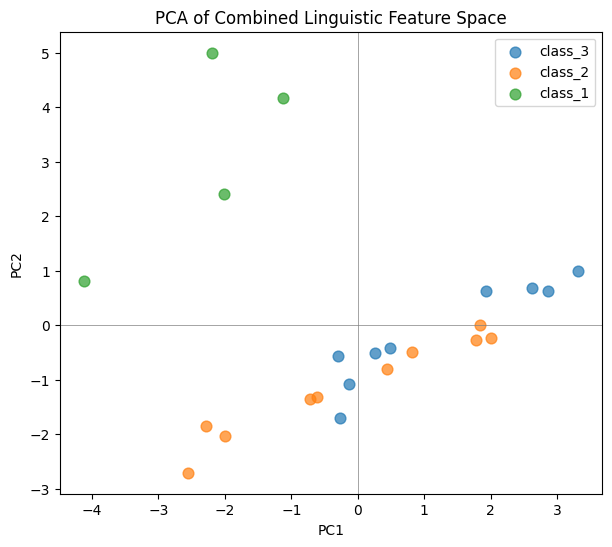

In [73]:
plt.figure(figsize=(7, 6))

for cls in pca_df["class"].unique():
    subset = pca_df[pca_df["class"] == cls]
    plt.scatter(
        subset["PC1"],
        subset["PC2"],
        label=cls,
        alpha=0.7,
        s=60
    )

plt.axhline(0, color="grey", lw=0.5)
plt.axvline(0, color="grey", lw=0.5)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Combined Linguistic Feature Space")
plt.legend()
plt.show()


Try with 3 components for a better spread 

In [74]:
pca3 = PCA(n_components=3)
X_pca_3 = pca3.fit_transform(X)

print("Explained variance ratio (PC1, PC2, PC3):")
print(pca3.explained_variance_ratio_)
print("Total explained variance:", pca3.explained_variance_ratio_.sum())

Explained variance ratio (PC1, PC2, PC3):
[0.4016865  0.35512048 0.09924484]
Total explained variance: 0.8560518246851931


Great, most of the variance in the data is captured by the 3 PCs, lets now move to centroids to check actual overlap

In [75]:
pca3_df = pd.DataFrame(
    X_pca_3,
    columns=["PC1", "PC2", "PC3"],
    index=feature_df_std.index
)

pca3_df["class"] = y.values
pca3_df["filename"] = feature_df_std["filename"].values


In [80]:
centroids_3d = (
    pca3_df
    .groupby("class")[["PC1", "PC2", "PC3"]]
    .mean()
)

print(centroids_3d)

              PC1       PC2       PC3
class                                
class_1 -2.360991  3.099368 -0.104486
class_2 -0.130597 -1.105537  0.186313
class_3  1.194438 -0.149122 -0.160576


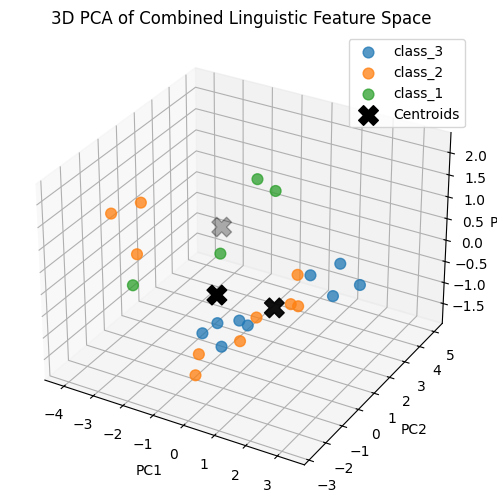

In [81]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

for cls in pca3_df["class"].unique():
    subset = pca3_df[pca3_df["class"] == cls]
    ax.scatter(
        subset["PC1"],
        subset["PC2"],
        subset["PC3"],
        label=cls,
        s=60,
        alpha=0.75
    )


ax.scatter(
    centroids_3d["PC1"],
    centroids_3d["PC2"],
    centroids_3d["PC3"],
    c="black",
    s=200,
    marker="X",
    label="Centroids"
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA of Combined Linguistic Feature Space")
ax.legend()
plt.show()

In [83]:
dist_matrix = squareform(pdist(centroids_3d.values))

dist_df = pd.DataFrame(
    dist_matrix,
    index=centroids_3d.index,
    columns=centroids_3d.index
)

dist_df

class,class_1,class_2,class_3
class,,,
class_1,0.000000,4.768694,4.816317
class_2,4.768694,0.000000,1.670563
class_3,4.816317,1.670563,0.000000


This is not sufficient, the data in the graph looks quite spread out. Even though centroids are far apart, its a problem if their spread is huge and overlapping.

Lets calculate avg distance of points in each classs from their centroid to get a better sense of the spread

In [84]:
within_class_dist = {}

for cls in pca3_df["class"].unique():
    points = pca3_df[pca3_df["class"] == cls][["PC1", "PC2", "PC3"]].values
    centroid = centroids_3d.loc[cls].values
    
    dists = np.linalg.norm(points - centroid, axis=1)
    within_class_dist[cls] = dists.mean()

within_class_dist


{'class_3': np.float64(1.681857311278729),
 'class_2': np.float64(2.136124475843819),
 'class_1': np.float64(1.9163982155529358)}

Strong Results from PCA 

85-86% total variance captured across 3 PC's. 

Lets use the sum of within_class_dists of class A and B and compare them to centroid distance 
- Human-AI: 1.9+2.1 = 4 which is lower than centroid distance of 4.7. (No overlap)
- AI- AI_mimic: 1.6+2.13 = 3.7 , higher than centroid disntace of 1.6. (Distinct but considerable overlap)
- Human-AI_mimic: 1.6+1.9 = 3.5, lower than centroid distance of 4.8. (No overlap)

(Human and mimic are father apart than just plain AI, interesting. I'll try looking into that T_T)


AI in general has more spread in its style whereas the AI_mimic trying to maintain a set specific style has a much smaller spread. 


Conclusion: Class 1 is clearly distinct, Class 2 and 3 are not completely distinct but a small overlap exists.
